In [1]:
import numpy as np
from scipy.special import softmax

import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [2]:
CLIP_THRESHOLD = 0.2
max_mw_per_node = 5
max_mw_per_hour = 20 # This is a soft limit - decrease a bit if you want it to be a bit lower in reality

In [3]:
x = np.array([-5, 2, 0.1, -0.05, 1, -3, 0.5, -4, 6, 3])
x_axis = np.array(range(0, len(x)))

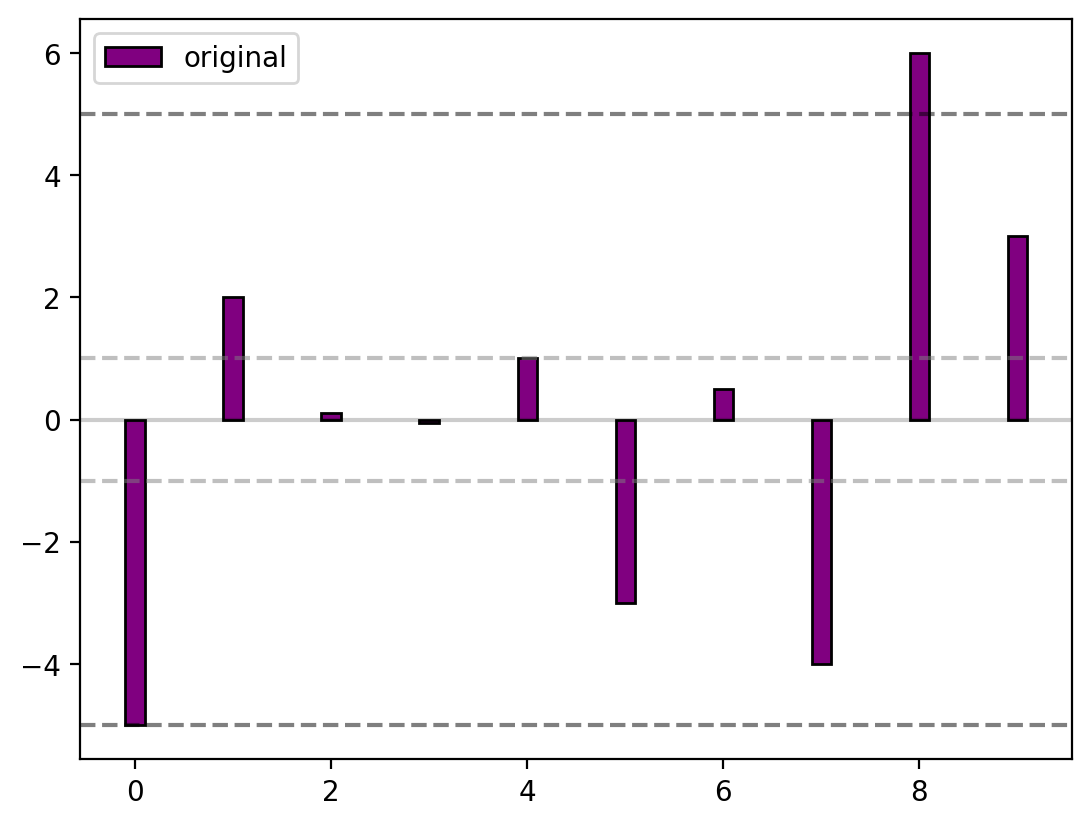

In [4]:
plt.bar(x_axis, x, width=0.2, color='purple', label='original', alpha=1, edgecolor='black')
plt.axhline(1, color='grey', linestyle='--', alpha=0.5)
plt.axhline(-1, color='grey', linestyle='--', alpha=0.5)
plt.axhline(max_mw_per_node, color='black', linestyle='--', alpha=0.5)
plt.axhline(-max_mw_per_node, color='black', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linestyle='-', alpha=0.2)
plt.legend()
plt.show()




In [5]:
sum_abs = np.abs(x).sum()
sf = np.max([sum_abs / max_mw_per_hour, 1])
xp0 = x / sf

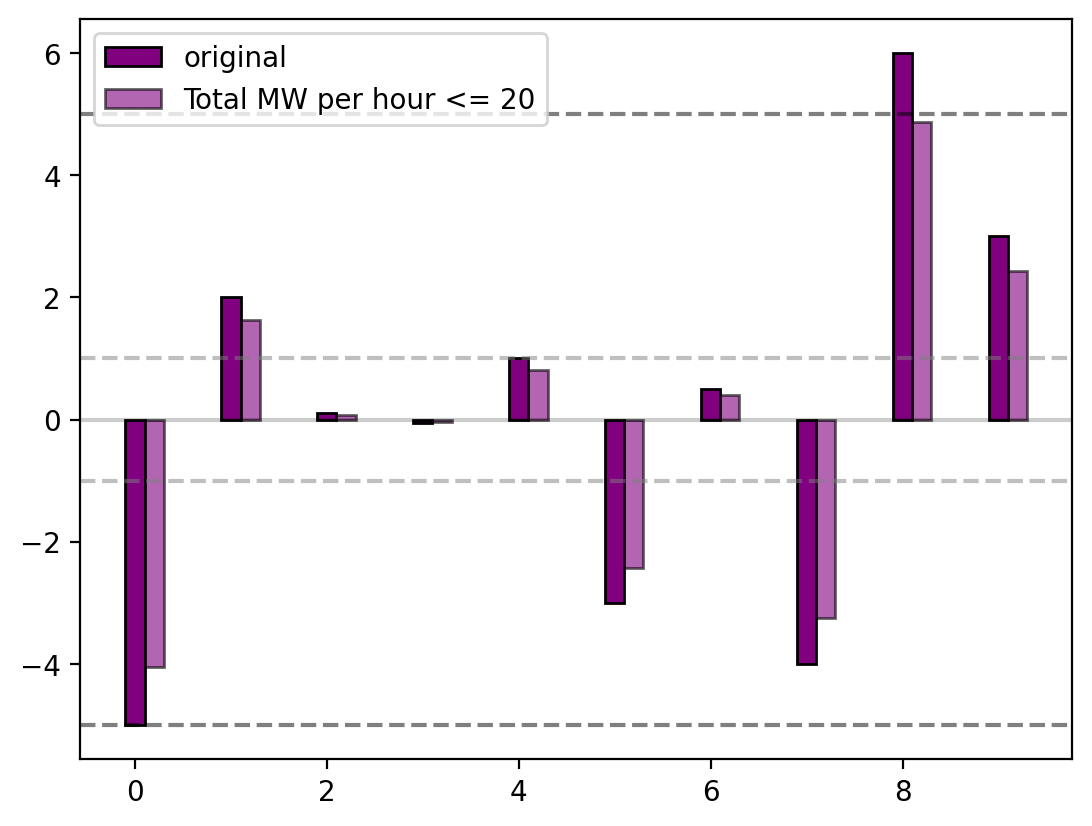

In [6]:
plt.bar(x_axis, x, width=0.2, color='purple', label='original', alpha=1, edgecolor='black')
plt.bar(x_axis+0.2, xp0, width=0.2, color='purple', label=f'Total MW per hour <= {max_mw_per_hour}', alpha=0.6, linewidth=1, edgecolor='black')
plt.axhline(1, color='grey', linestyle='--', alpha=0.5)
plt.axhline(-1, color='grey', linestyle='--', alpha=0.5)
plt.axhline(max_mw_per_node, color='black', linestyle='--', alpha=0.5)
plt.axhline(-max_mw_per_node, color='black', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linestyle='-', alpha=0.2)

plt.legend()
plt.show()




In [7]:
def f(x): 
    x_sign = np.sign(x)
    x_abs = np.abs(x)
    x = np.where(x_abs < CLIP_THRESHOLD, 0, x_abs + (1 - CLIP_THRESHOLD)) * x_sign
    return x

In [8]:
xp1 = f(xp0)

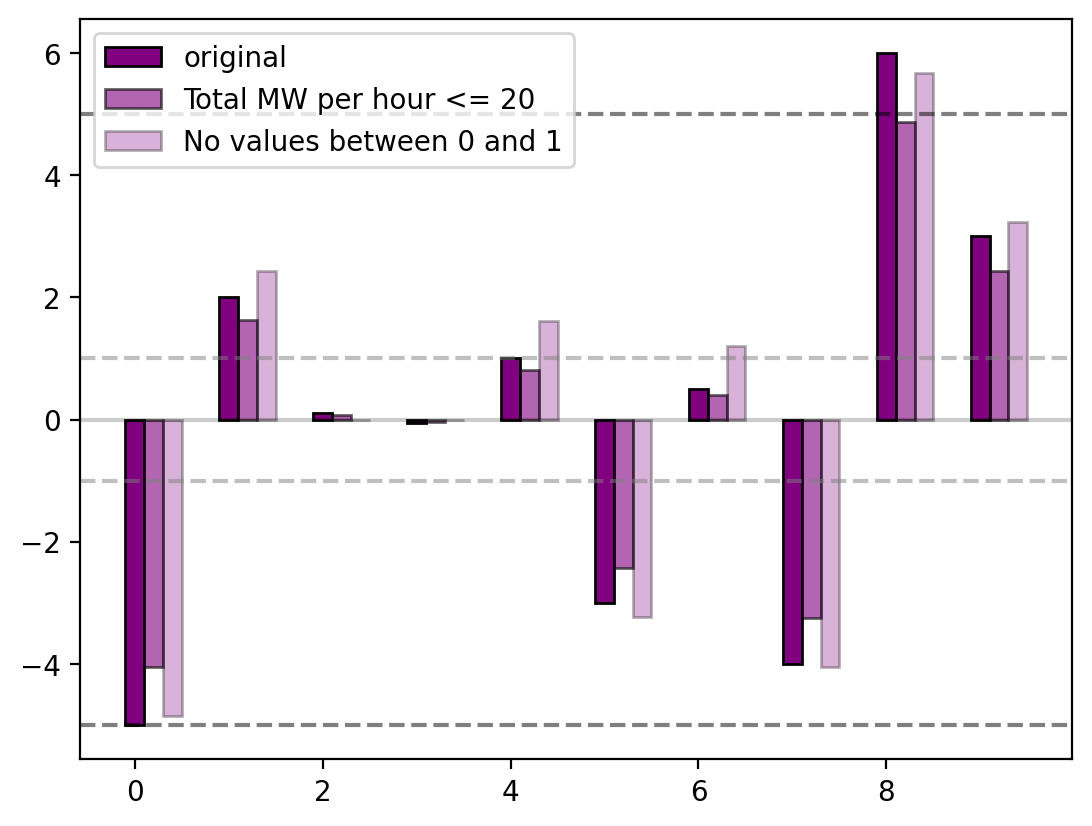

In [9]:
plt.bar(x_axis, x, width=0.2, color='purple', label='original', alpha=1, edgecolor='black')
plt.bar(x_axis+0.2, xp0, width=0.2, color='purple', label=f'Total MW per hour <= {max_mw_per_hour}', alpha=0.6, linewidth=1, edgecolor='black')
plt.bar(x_axis+0.4, xp1, width=0.2, color='purple', label='No values between 0 and 1', alpha=0.3, linewidth=1, edgecolor='black')
plt.axhline(1, color='grey', linestyle='--', alpha=0.5)
plt.axhline(-1, color='grey', linestyle='--', alpha=0.5)
plt.axhline(max_mw_per_node, color='black', linestyle='--', alpha=0.5)
plt.axhline(-max_mw_per_node, color='black', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linestyle='-', alpha=0.2)

plt.legend()
plt.show()




In [10]:
# network_selected_mw_per_side = np.mean([np.abs(xp1[xp1 < 0].sum()), xp1[xp1 > 0].sum()])
# mw_per_side = np.min([max_mw_per_side, network_selected_mw_per_side])

# mw_per_side

In [27]:
# xp2 = np.where(np.abs(xp1) > max_mw_per_node, max_mw_per_node * np.sign(xp1), xp1)
xp2 = np.clip(xp1, -max_mw_per_node, max_mw_per_node)

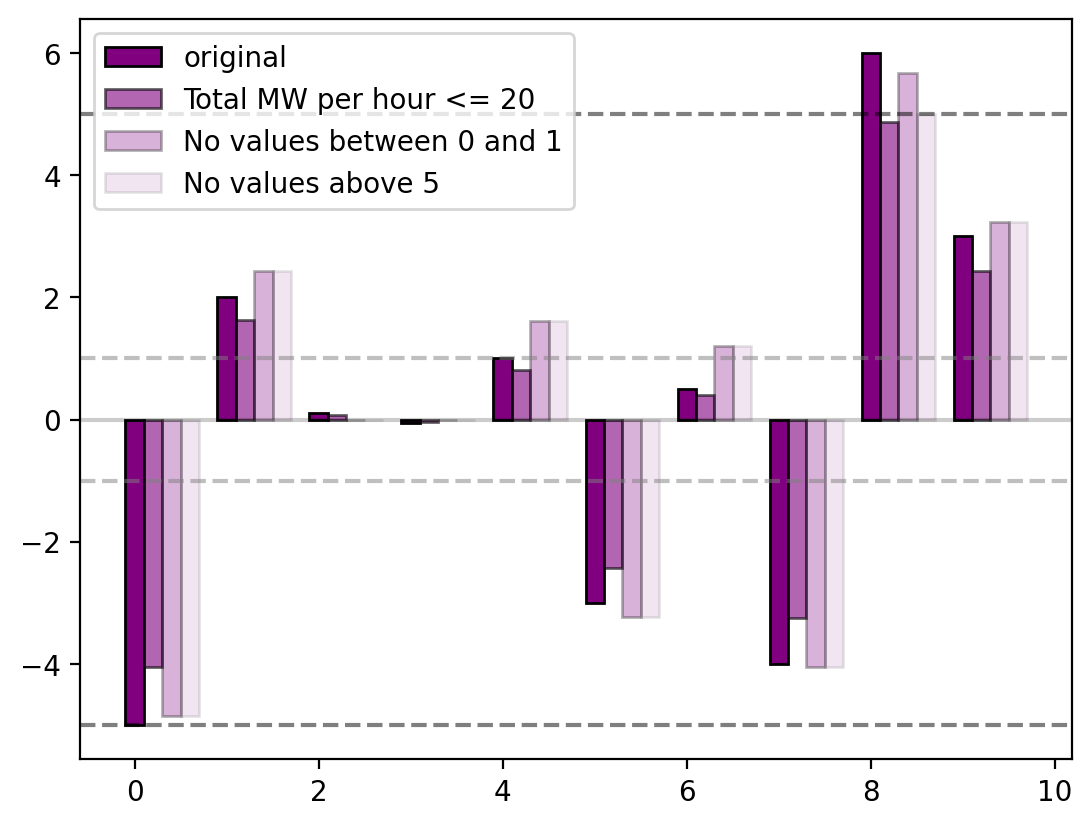

In [28]:
plt.bar(x_axis, x, width=0.2, color='purple', label='original', alpha=1, edgecolor='black')
plt.bar(x_axis+0.2, xp0, width=0.2, color='purple', label=f'Total MW per hour <= {max_mw_per_hour}', alpha=0.6, linewidth=1, edgecolor='black')
plt.bar(x_axis+0.4, xp1, width=0.2, color='purple', label='No values between 0 and 1', alpha=0.3, linewidth=1, edgecolor='black')
plt.bar(x_axis+0.6, xp2, width=0.2, color='purple', label=f'No values above {max_mw_per_node}', alpha=0.1, linewidth=1, edgecolor='black')

plt.axhline(1, color='grey', linestyle='--', alpha=0.5)
plt.axhline(-1, color='grey', linestyle='--', alpha=0.5)
plt.axhline(max_mw_per_node, color='black', linestyle='--', alpha=0.5)
plt.axhline(-max_mw_per_node, color='black', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linestyle='-', alpha=0.2)

plt.legend()
plt.show()




In [29]:
# Time to balance!
# Goal: remove mw from the side that has extra (don't try and increase the side that has too much)
# Note: we can't remove in parallel or else we may violate our lower bound of 1 mw constraint

In [43]:
total_amount_to_remove = xp2.sum()

xp2_pos = np.where(xp2 >= 1, xp2, 0)

amount_able_to_remove = np.where(xp2_pos != 0, xp2_pos - 1, 0)

ratio = amount_able_to_remove.sum() / total_amount_to_remove.sum()

amount_to_remove = amount_able_to_remove / ratio

xp3 = np.where(xp2 >= 1, xp2_pos - amount_to_remove, xp2)


-8.881784197001252e-16


<BarContainer object of 10 artists>

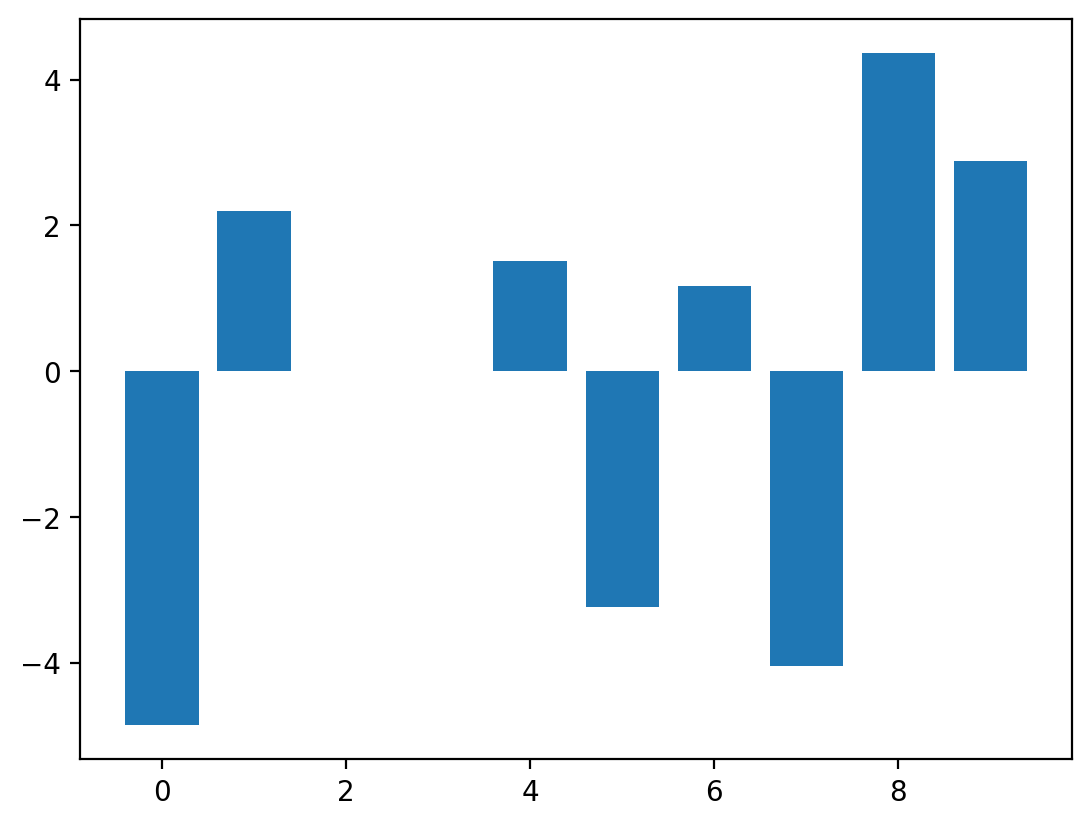

In [45]:
print(xp3.sum())
plt.bar(x_axis, xp3)

In [46]:
def test(x):
    assert x.sum().round(5) == 0 # Balance
    assert np.abs(x).max() <= max_mw_per_node
    assert np.abs(x).sum() <= max_mw_per_hour + 10 # TODO: don't make a user think about this
    assert not ((np.abs(xp3) <= 1) & (np.abs(xp3) > 1)).any()


In [47]:
test(xp3)

In [48]:
def transform(x): 
    
    # Scale total volume
    sum_abs = np.abs(x).sum()
    sf = np.max([sum_abs / max_mw_per_hour, 1])
    x = x / sf

    # Threshold to be equal to 0 or abs(val) gte 1
    x_sign = np.sign(x)
    x_abs = np.abs(x)
    x = np.where(x_abs < CLIP_THRESHOLD, 0, x_abs + (1 - CLIP_THRESHOLD)) * x_sign
    
    # Clamp to max_mw_per_node
    x = np.clip(x, -max_mw_per_node, max_mw_per_node)
    
    # Balance - assume positive for now
    total_amount_to_remove = x.sum()
    x_pos = np.where(x >= 1, x, 0)
    amount_able_to_remove = np.where(x_pos != 0, x_pos - 1, 0)
    ratio = amount_able_to_remove.sum() / total_amount_to_remove.sum()
    amount_to_remove = amount_able_to_remove / ratio
    x = np.where(x >= 1, x_pos - amount_to_remove, x)

    return x

In [49]:
xp = transform(x)

In [50]:
test(xp)

-8.881784197001252e-16


<BarContainer object of 10 artists>

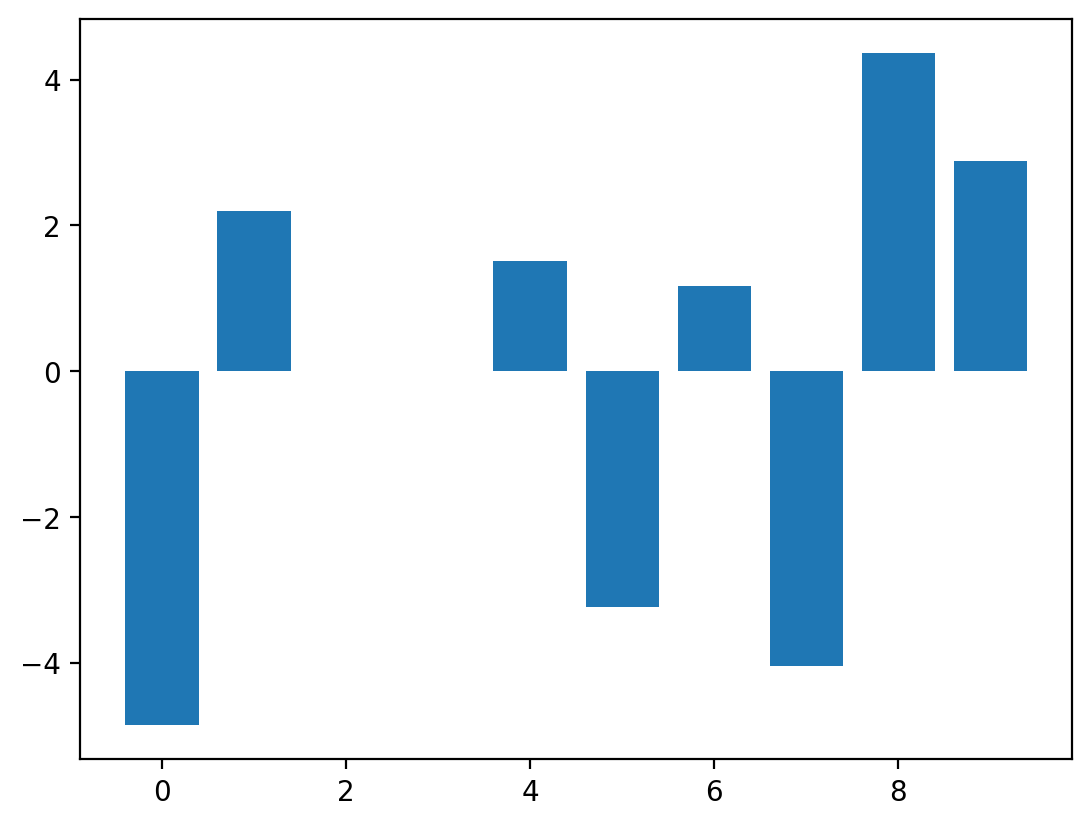

In [51]:
print(xp.sum())
plt.bar(x_axis, xp)

# In pytorch

In [52]:
def plot_allocation(x):
    plt.bar(x=range(0, len(x[0])), height=x[0].flatten())
    plt.show()

In [53]:
import torch

In [72]:
CLIP_THRESHOLD = 0.2
max_mw_per_node = 8
max_mw_per_hour = 30

Abs sum:  tensor(109.6000)
Abs sum:  tensor(20.)


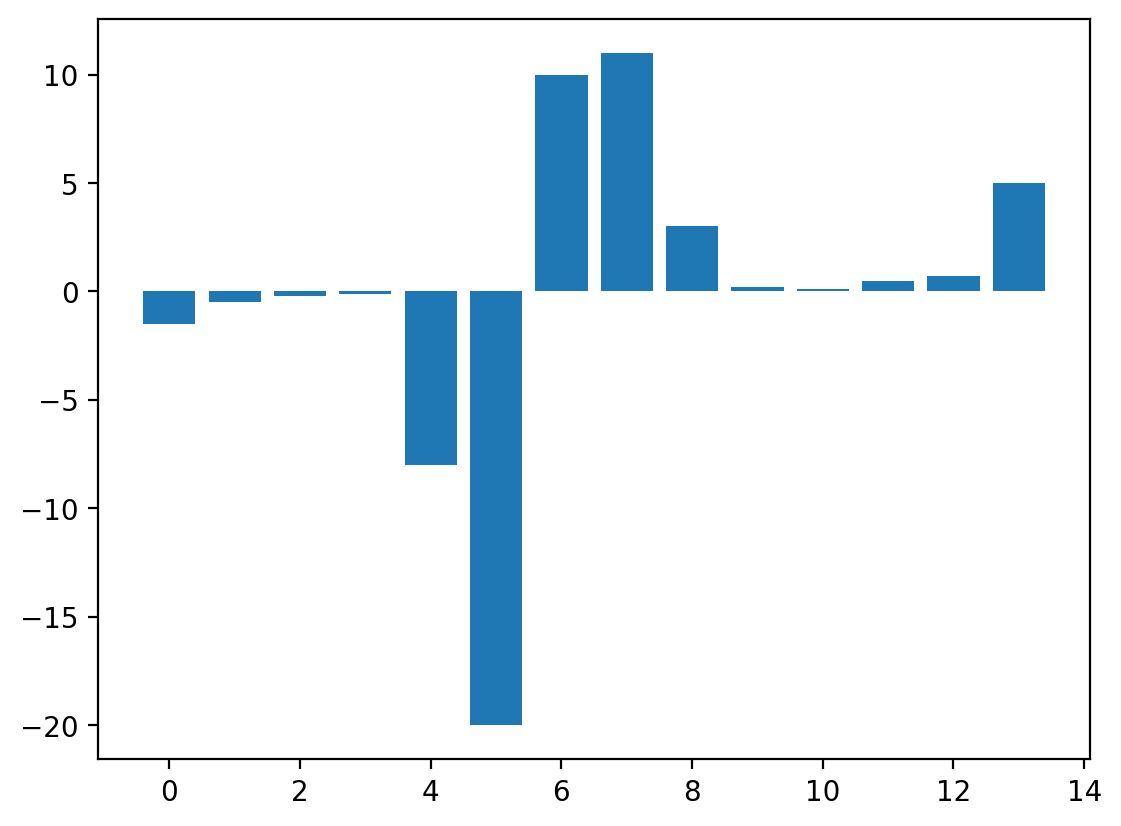

In [97]:
x = torch.tensor([
    [-1.5, -0.5, -0.2, -0.1, -8, -20, 10, 11, 3, 0.2, 0.1, 0.5, 0.7, 5],
    [-1.5, -0.5, -0.2, -0.1, -8, -20, 5, 6, 3, 0.2, 0.1, 0.5, 0.7, 3]
])[..., None]

print('Abs sum: ', x.abs().sum())
print('Abs sum: ', x.abs().max())


plot_allocation(x)

In [98]:
x.shape

torch.Size([2, 14, 1])

In [99]:
def transform(x): 
    
    # Scale sum to enforce absolute value is lte to max_mw_per_hour
    sum_abs = np.abs(x).sum()
    sf = np.max([sum_abs / max_mw_per_hour, 1])
    x = x / sf

    # Threshold to be equal to 0 or abs(val) gte 1
    x_sign = np.sign(x)
    x_abs = np.abs(x)
    x = np.where(x_abs < CLIP_THRESHOLD, 0, x_abs + (1 - CLIP_THRESHOLD)) * x_sign
    
    # Clamp to max_mw_per_node
    x = np.clip(x, -max_mw_per_node, max_mw_per_node)
    
    # Balance - assume positive for now
    total_amount_to_remove = x.sum()
    x_pos = np.where(x >= 1, x, 0)
    amount_able_to_remove = np.where(x_pos != 0, x_pos - 1, 0)
    ratio = amount_able_to_remove.sum() / total_amount_to_remove.sum()
    amount_to_remove = amount_able_to_remove / ratio
    x = np.where(x >= 1, x_pos - amount_to_remove, x)

    return x

In [185]:
def transform_torch(x):
    # Scale sum to enforce absolute value is lte to max_mw_per_hour
    sum_abs = x.abs().sum(dim=1, keepdim=True)
    scale_factor = torch.max(sum_abs / max_mw_per_hour, torch.tensor([1]))
    x = x / scale_factor    

    # Clamp values above 0 and below 1 to 0
    x = torch.where(
        x.abs() < CLIP_THRESHOLD,
        torch.zeros_like(x),
        (x.abs() + (1 - CLIP_THRESHOLD)) * x.sign()
    )

    # Clamping the output to be between -max_mw_per_node and max_mw_per_node
    x = torch.clamp(x, min=-max_mw_per_node, max=max_mw_per_node)

    # Balance
    total_amount_to_remove = x.sum(dim=1)
    x_to_remove_from = torch.where(
        x.sign() == total_amount_to_remove.sign()[..., None],
        x,
        0
    )
    amount_able_to_remove = torch.where(
        x_to_remove_from != 0, 
        (x_to_remove_from.abs() - 1) * x_to_remove_from.sign(), 
        0
    )
    ratio = amount_able_to_remove.sum(dim=1) / total_amount_to_remove.sum(dim=1)[..., None]
    amount_to_remove = amount_able_to_remove / ratio[..., None]
    x = x - amount_to_remove

    return x

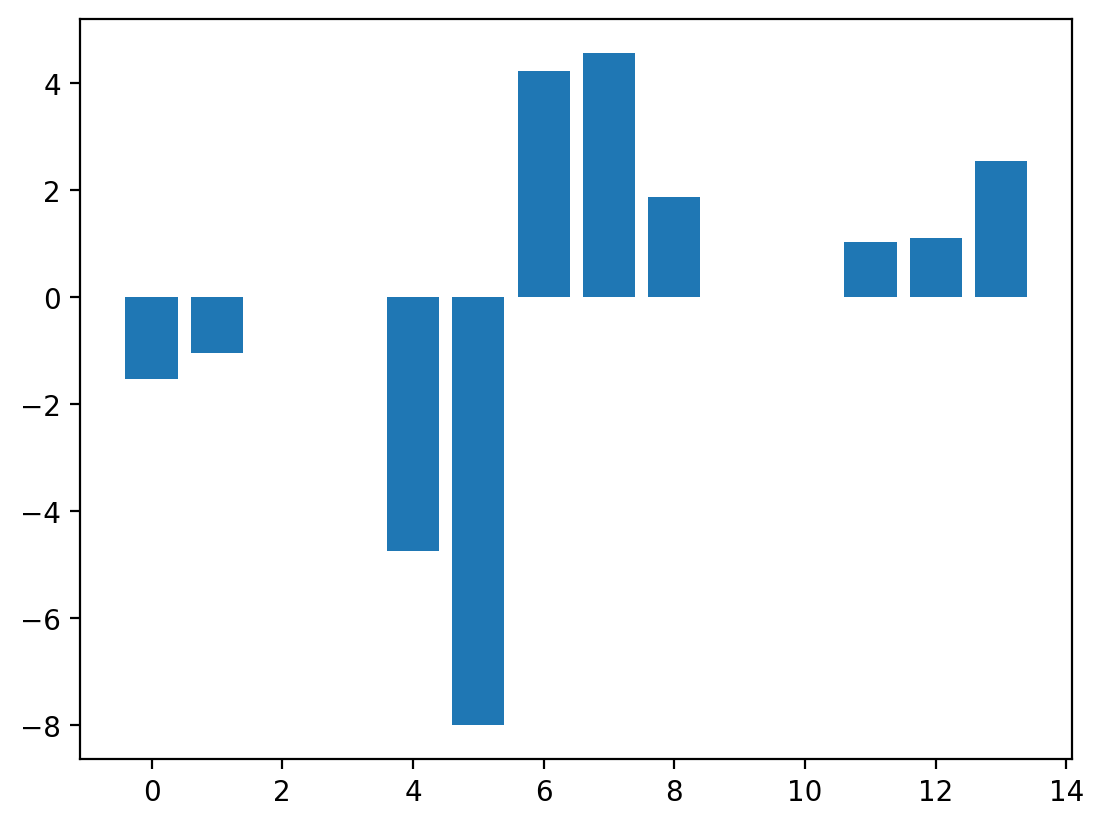

In [186]:
xp = transform_torch(x)
plot_allocation(xp)

In [184]:
total_amount_to_remove = xp.sum(dim=1)
xp_to_remove_from = torch.where(
    xp.sign() == total_amount_to_remove.sign()[..., None],
    xp,
    0
)
amount_able_to_remove = torch.where(xp_to_remove_from != 0, (xp_to_remove_from.abs() - 1) * xp_to_remove_from.sign(), 0)
ratio = amount_able_to_remove.sum(dim=1) / total_amount_to_remove.sum(dim=1)[..., None]
amount_to_remove = amount_able_to_remove / ratio[..., None]
xp = xp - amount_to_remove

In [172]:
amount_able_to_remove.shape, ratio[..., None].shape

(torch.Size([2, 14, 1]), torch.Size([2, 1, 1]))

In [176]:
amount_to_remove = amount_able_to_remove / ratio[..., None]
amount_to_remove.sum(dim=1)

tensor([[ 4.3671],
        [-0.5590]])

In [178]:
amount_to_remove

tensor([[[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 1.5090],
         [ 1.6662],
         [ 0.4081],
         [ 0.0000],
         [ 0.0000],
         [ 0.0149],
         [ 0.0463],
         [ 0.7226]],

        [[-0.0322],
         [-0.0048],
         [ 0.0000],
         [ 0.0000],
         [-0.2102],
         [-0.3119],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]]])

In [180]:
(xp - amount_to_remove).sum(dim=1)

tensor([[9.5367e-07],
        [0.0000e+00]])

In [ ]:
x = np.where(x >= 1, x_pos - amount_to_remove, x)

In [147]:
amount_able_to_remove.sum(dim=1)

tensor([[ 13.7013],
        [-12.5475]])

In [151]:
total_amount_to_remove.shape, amount_able_to_remove.sum(dim=1).shape

(torch.Size([2, 1]), torch.Size([2, 1]))

tensor([[ 3.1374],
        [22.4457]])

In [156]:
amount_able_to_remove.sum(dim=1).shape, total_amount_to_remove.sum(dim=1)[..., None].shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [158]:
amount_able_to_remove.sum(dim=1) / total_amount_to_remove.sum(dim=1)[..., None]

tensor([[ 3.1374],
        [22.4457]])

In [ ]:
# Balance - assume positive for now
# total_amount_to_remove = x.sum()
# x_pos = np.where(x >= 1, x, 0)
# amount_able_to_remove = np.where(x_pos != 0, x_pos - 1, 0)
# ratio = amount_able_to_remove.sum() / total_amount_to_remove.sum()
amount_to_remove = amount_able_to_remove / ratio
x = np.where(x >= 1, x_pos - amount_to_remove, x)

In [192]:
def test_x_is_constrained(x):
    assert (x.abs().sum(dim=1) <= max_mw_per_hour * 1.5).all()
    print('Total mw <= max_mw_per_hour ----------> Passed! ✅')

    assert ~((x > 0) & (x <= 1)).any()    
    print('No values between 0 and 1 ----------> Passed! ✅')

    assert (x.abs().max(dim=1).values <= max_mw_per_node).all()
    print('Max val <= max_mw_per_node ----------> Passed! ✅')
    
    assert (x.sum(dim=1) <= 1e-5).all()
    print('Balanced ----------> Passed! ✅')
    

    print('x is properly constrained! ✅')

In [193]:
test_x_is_constrained(transform_torch(x))

Total mw <= max_mw_per_hour ----------> Passed! ✅
No values between 0 and 1 ----------> Passed! ✅
Max val <= max_mw_per_node ----------> Passed! ✅
Balanced ----------> Passed! ✅
x is properly constrained! ✅
